In [9]:
# ============================================================================
# CELDA 1: IMPORTS
# ============================================================================

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import time
from datetime import datetime
import warnings
import pickle
warnings.filterwarnings('ignore')

from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import optuna

print("✅ Imports completados")
print(f"📅 {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Imports completados
📅 2025-11-24 00:49:37


In [10]:
# ============================================================================
# CELDA 2: CONFIGURACIÓN
# ============================================================================

EXPERIMENT_CONFIG = {
    'model_name': 'CATBOOST',
    'target_variable': 'PEN_log_ret',
    'step_size': 21,
    'n_holdout': 60,
    'min_train_size': 252,
    'random_seed': 42,
    'cv_folds': 3,
    'optuna_timeout': 7200,  # 2 horas
    'checkpoint_every': 5,
}

DIRS = {
    'data': Path('.'),
    'predictions': Path('predictions_dump'),
    'oof': Path('oof_predictions'),  # ✅ NUEVO
    'checkpoints': Path('checkpoints/catboost'),
    'reports': Path('reports/catboost'),
}

for name, path in DIRS.items():
    if name not in ['data']:
        path.mkdir(parents=True, exist_ok=True)


print("✅ Configuración lista")
for k, v in EXPERIMENT_CONFIG.items():
    print(f"   {k}: {v}")

✅ Configuración lista
   model_name: CATBOOST
   target_variable: PEN_log_ret
   step_size: 21
   n_holdout: 60
   min_train_size: 252
   random_seed: 42
   cv_folds: 3
   optuna_timeout: 7200
   checkpoint_every: 5


In [11]:
# ============================================================================
# CELDA 3: CARGAR DATOS Y FEATURE ENGINEERING (CORREGIDO - SIN LEAKAGE)
# ============================================================================

print("📂 Cargando DATA.csv...")
df = pd.read_csv('DATA.csv')

date_col = df.columns[0]
df[date_col] = pd.to_datetime(df[date_col])
df = df.sort_values(date_col).reset_index(drop=True)

print(f"✅ Datos cargados: {df.shape}")
print(f"   Periodo: {df[date_col].min()} a {df[date_col].max()}")

# ============================================================================
# FEATURE ENGINEERING SIN LEAKAGE
# ============================================================================
print("\n🔧 Generando features (anti-leakage)...")

# 1. Target (log returns de PEN)
df['PEN_log_ret'] = np.log(df['PEN'] / df['PEN'].shift(1))

# 2. Lags del target (AR features) - SOLO LAGS
ar_lags = [1, 2, 3, 5, 10, 21]
for lag in ar_lags:
    df[f'PEN_log_ret_lag_{lag}'] = df['PEN_log_ret'].shift(lag)

# ============================================================================
# ⚠️ VARIABLES EXÓGENAS - SOLO LAGS (NO CONTEMPORÁNEAS)
# ============================================================================
exog_vars = ['MXN', 'CLP', 'COBRE', 'DXY', 'UST10Y']

for var in exog_vars:
    # Log return intermedio (solo para calcular lags)
    log_ret_temp = np.log(df[var] / df[var].shift(1))
    
    # ✅ SOLO GUARDAR LAGS (t-1, t-2, ...)
    df[f'{var}_log_ret_lag_1'] = log_ret_temp.shift(1)  # t-1
    df[f'{var}_log_ret_lag_2'] = log_ret_temp.shift(2)  # t-2 (opcional)
    
    # ❌ NO guardar log_ret_temp directamente (sería tiempo t)

# ============================================================================
# ⚠️ VARIABLES MACRO - SOLO LAGS
# ============================================================================
macro_vars = ['CPI', 'MXPE', 'RESERV', 'T_TRADE', 'Tasa_cds']

for var in macro_vars:
    if var in df.columns:
        # ✅ SOLO lags (no valor contemporáneo)
        df[f'{var}_lag_1'] = df[var].shift(1)
        df[f'{var}_lag_2'] = df[var].shift(2)  # Opcional para mayor historia

# ============================================================================
# GARCH volatility - Usando SOLO historia pasada
# ============================================================================
df['GARCH_vol'] = df['PEN_log_ret'].shift(1).rolling(window=21, min_periods=10).std()
# ⚠️ shift(1) ANTES del rolling para asegurar que usa solo hasta t-1

# ============================================================================
# Features temporales cíclicos (estos SÍ pueden ser contemporáneos)
# ============================================================================
df['day_of_week'] = df[date_col].dt.dayofweek
df['month'] = df[date_col].dt.month
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# ============================================================================
# Indicadores técnicos - SOLO con historia pasada
# ============================================================================
# RSI - calculado con ventana que termina en t-1
delta = df['PEN_log_ret'].shift(1)  # ⚠️ shift(1) primero
gain = (delta.where(delta > 0, 0)).rolling(window=14, min_periods=7).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14, min_periods=7).mean()
rs = gain / (loss + 1e-10)
df['RSI'] = 100 - (100 / (1 + rs))

# MACD - usando precios hasta t-1
pen_shifted = df['PEN'].shift(1)  # ⚠️ shift(1) primero
exp1 = pen_shifted.ewm(span=12, adjust=False).mean()
exp2 = pen_shifted.ewm(span=26, adjust=False).mean()
df['MACD'] = exp1 - exp2
df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# Renombrar
df = df.rename(columns={date_col: 'Fecha'})

print(f"✅ Feature engineering sin leakage completado")
print(f"   Total columnas: {len(df.columns)}")
print(f"   Obs con target: {df['PEN_log_ret'].notna().sum()}")

# ============================================================================
# IDENTIFICAR FEATURES - SOLO CON LAG O CÍCLICAS
# ============================================================================
all_cols = df.columns.tolist()

# AR features (solo lags)
ar_features = [col for col in all_cols if 'PEN_log_ret_lag' in col]

# Temporal features (cíclicos están OK)
temporal_features = [col for col in all_cols if any(x in col for x in ['_sin', '_cos'])]

# ✅ EXOGENOUS: Solo features con "_lag_" en el nombre
exog_features = [col for col in all_cols 
                if '_lag_' in col  # ⚠️ CRÍTICO: solo lags
                and 'PEN_log_ret_lag' not in col  # Excluir AR (ya incluidos)
                and df[col].dtype in ['float64', 'int64']]

# Agregar indicadores técnicos (ya calculados sin leakage)
technical_features = ['RSI', 'MACD', 'MACD_signal', 'GARCH_vol']
technical_features = [f for f in technical_features if f in df.columns]

# Features completas
all_features = ar_features + temporal_features + exog_features + technical_features

print(f"\n📊 Features ANTI-LEAKAGE:")
print(f"   AR features (lags): {len(ar_features)}")
print(f"      {ar_features}")
print(f"   Temporal (cíclicos): {len(temporal_features)}")
print(f"      {temporal_features}")
print(f"   Exog (solo lags): {len(exog_features)}")
print(f"      {exog_features[:10]}...")
print(f"   Technical: {len(technical_features)}")
print(f"      {technical_features}")
print(f"   TOTAL: {len(all_features)}")

# ============================================================================
# VERIFICACIÓN ANTI-LEAKAGE
# ============================================================================
print(f"\n🔍 Verificación anti-leakage:")

# Verificar que NO hay variables contemporáneas
suspicious = []
for feat in all_features:
    # Buscar features que NO tengan lag ni sean cíclicas ni sean indicadores técnicos conocidos
    if ('_lag_' not in feat and 
        '_sin' not in feat and 
        '_cos' not in feat and
        feat not in ['RSI', 'MACD', 'MACD_signal', 'GARCH_vol']):
        suspicious.append(feat)

if suspicious:
    print(f"   ⚠️  POSIBLES LEAKS DETECTADOS: {suspicious}")
    print(f"   Revisa estas features manualmente")
else:
    print(f"   ✅ No se detectaron leaks obvios")
    
# Verificar que exog solo tiene lags
exog_no_lag = [f for f in exog_features if '_lag_' not in f]
if exog_no_lag:
    print(f"   ⚠️  Features exógenas SIN lag: {exog_no_lag}")
else:
    print(f"   ✅ Todas las exógenas tienen lag")

📂 Cargando DATA.csv...
✅ Datos cargados: (8201, 12)
   Periodo: 1994-01-31 00:00:00 a 2025-07-07 00:00:00

🔧 Generando features (anti-leakage)...
✅ Feature engineering sin leakage completado
   Total columnas: 49
   Obs con target: 8200

📊 Features ANTI-LEAKAGE:
   AR features (lags): 6
      ['PEN_log_ret_lag_1', 'PEN_log_ret_lag_2', 'PEN_log_ret_lag_3', 'PEN_log_ret_lag_5', 'PEN_log_ret_lag_10', 'PEN_log_ret_lag_21']
   Temporal (cíclicos): 4
      ['day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos']
   Exog (solo lags): 20
      ['MXN_log_ret_lag_1', 'MXN_log_ret_lag_2', 'CLP_log_ret_lag_1', 'CLP_log_ret_lag_2', 'COBRE_log_ret_lag_1', 'COBRE_log_ret_lag_2', 'DXY_log_ret_lag_1', 'DXY_log_ret_lag_2', 'UST10Y_log_ret_lag_1', 'UST10Y_log_ret_lag_2']...
   Technical: 4
      ['RSI', 'MACD', 'MACD_signal', 'GARCH_vol']
   TOTAL: 34

🔍 Verificación anti-leakage:
   ✅ No se detectaron leaks obvios
   ✅ Todas las exógenas tienen lag


In [12]:
# ============================================================================
# CELDA 4: TRAIN/HOLDOUT SPLIT
# ============================================================================

n_holdout = EXPERIMENT_CONFIG['n_holdout']

# Solo datos con target válido
valid_data = df[df['PEN_log_ret'].notna()].copy()

# Split
train_full = valid_data.iloc[:-n_holdout].copy()
holdout = valid_data.iloc[-n_holdout:].copy()

print(f"✅ Train/Holdout split:")
print(f"   Train: {len(train_full)} obs ({train_full['Fecha'].min()} a {train_full['Fecha'].max()})")
print(f"   Holdout: {len(holdout)} obs ({holdout['Fecha'].min()} a {holdout['Fecha'].max()})")
print(f"   Features: {len(all_features)}")

✅ Train/Holdout split:
   Train: 8140 obs (1994-02-01 00:00:00 a 2025-04-14 00:00:00)
   Holdout: 60 obs (2025-04-15 00:00:00 a 2025-07-07 00:00:00)
   Features: 34


In [13]:
# ============================================================================
# CELDA 5: WRAPPER DE CATBOOST
# ============================================================================

class CatBoostWrapper:
    def __init__(self, features, model_params=None):
        self.features = features
        default_params = {
            'iterations': 100,
            'depth': 6,
            'learning_rate': 0.05,
            'l2_leaf_reg': 3,
            'random_seed': 42,
            'verbose': False,
            'task_type': 'GPU',
            'devices': '0'
        }
        if model_params:
            default_params.update(model_params)
        self.model_params = default_params
        self.model = None
        self.scaler_X = StandardScaler()
        self.scaler_y = StandardScaler()
    
    def fit(self, X_train, y_train):
        X_scaled = self.scaler_X.fit_transform(X_train[self.features])
        y_scaled = self.scaler_y.fit_transform(y_train.values.reshape(-1, 1))
        self.model = CatBoostRegressor(**self.model_params)
        self.model.fit(X_scaled, y_scaled.ravel(), verbose=False)
        return self
    
    def predict(self, X_test):
        X_scaled = self.scaler_X.transform(X_test[self.features])
        y_pred_scaled = self.model.predict(X_scaled)
        y_pred = self.scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
        return y_pred.ravel()

def compute_directional_accuracy(y_true, y_pred):
    return (np.sign(y_true) == np.sign(y_pred)).mean() * 100

print("✅ Wrapper definido")

✅ Wrapper definido


In [14]:
# ============================================================================
# FUNCIÓN PARA GUARDAR PREDICCIONES OOF
# ============================================================================

def save_oof_predictions(predictions, dates, actuals, model_name='CATBOOST',
                         prediction_type='log_returns', metadata=None,
                         output_dir='oof_predictions'):
    """
    Guarda predicciones OOF en formato estándar para meta-learner.
    """
    os.makedirs(output_dir, exist_ok=True)
    
    df_oof = pd.DataFrame({
        'ds': dates,
        'y_pred': predictions,
        'y_real': actuals,
        'model': model_name,
        'type': prediction_type
    })
    
    filename = f'train_oof_{model_name}.csv'
    filepath = os.path.join(output_dir, filename)
    df_oof.to_csv(filepath, index=False)
    
    if metadata is not None:
        metadata['timestamp'] = datetime.now().isoformat()
        metadata['n_observations'] = len(predictions)
        
        meta_filename = f'train_oof_{model_name}_metadata.json'
        meta_filepath = os.path.join(output_dir, meta_filename)
        
        with open(meta_filepath, 'w') as f:
            json.dump(metadata, f, indent=2)
    
    print(f"\n✅ Guardado OOF: {filename}")
    print(f"   📊 Observaciones: {len(predictions)}")
    print(f"   📅 Rango: {dates.iloc[0] if hasattr(dates, 'iloc') else dates[0]} a {dates.iloc[-1] if hasattr(dates, 'iloc') else dates[-1]}")
    
    return filepath

print("✅ Función save_oof_predictions definida")

✅ Función save_oof_predictions definida


In [15]:
# ============================================================================
# CELDA 6: OPTUNA TUNING CON CHECKPOINTS (90-120 MIN)
# ============================================================================

start_tune = time.time()

print(f"🎯 Hyperparameter Tuning")
print(f"   Timeout: {EXPERIMENT_CONFIG['optuna_timeout']/60:.0f} min")
print(f"   CV Folds: {EXPERIMENT_CONFIG['cv_folds']}")
print(f"   Features: {len(all_features)}\n")

# Storage
study_name = f"catboost_{datetime.now().strftime('%Y%m%d_%H%M')}"
storage_path = f"sqlite:///optuna_studies/{study_name}.db"
Path('optuna_studies').mkdir(exist_ok=True)

# Checkpoint manager
class CheckpointManager:
    def __init__(self, checkpoint_dir):
        self.checkpoint_dir = Path(checkpoint_dir)
        self.checkpoint_dir.mkdir(parents=True, exist_ok=True)
    
    def save(self, study, trial_num):
        data = {
            'n_trials': len(study.trials),
            'best_value': float(study.best_value),
            'best_params': study.best_params,
            'timestamp': datetime.now().isoformat()
        }
        file = self.checkpoint_dir / f'checkpoint_trial_{trial_num}.json'
        with open(file, 'w') as f:
            json.dump(data, f, indent=2)
        return file

checkpoint_mgr = CheckpointManager(DIRS['checkpoints'])

# Callback
trial_times = []
checkpoint_counter = [0]

def callback(study, trial):
    elapsed = time.time() - start_tune
    trial_times.append(trial.duration.total_seconds())
    avg_time = np.mean(trial_times[-10:])
    remaining = EXPERIMENT_CONFIG['optuna_timeout'] - elapsed
    est_trials = max(0, int(remaining / avg_time))
    
    print(f"\n{'='*70}")
    print(f"✓ Trial {trial.number}: DA={trial.value:.2f}%")
    print(f"  Params: {trial.params}")
    print(f"  🏆 Best: {study.best_value:.2f}% (Trial {study.best_trial.number})")
    print(f"  ⏱️  {elapsed/60:.1f}min | ~{remaining/60:.1f}min restante | ~{est_trials} trials")
    
    checkpoint_counter[0] += 1
    if checkpoint_counter[0] % EXPERIMENT_CONFIG['checkpoint_every'] == 0:
        file = checkpoint_mgr.save(study, trial.number)
        print(f"  💾 Checkpoint: {file.name}")
    print(f"{'='*70}\n")

# Estudio
study = optuna.create_study(
    study_name=study_name,
    storage=storage_path,
    direction="maximize",
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(seed=42)
)

# Objetivo
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 50, 200),
        'depth': trial.suggest_int('depth', 4, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 20),
        'random_seed': 42,
        'verbose': False,
        'task_type': 'GPU',
        'devices': '0'
    }
    
    tscv = TimeSeriesSplit(n_splits=3, test_size=21, gap=0)
    X = train_full[all_features]
    y = train_full['PEN_log_ret']
    
    da_scores = []
    for train_idx, test_idx in tscv.split(X):
        if len(train_idx) < 252:
            continue
        model = CatBoostWrapper(all_features, params)
        model.fit(X.iloc[train_idx], y.iloc[train_idx])
        y_pred = model.predict(X.iloc[test_idx])
        da = compute_directional_accuracy(y.iloc[test_idx].values, y_pred)
        da_scores.append(da)
    
    return np.mean(da_scores) if da_scores else 0.0

# Optimizar
try:
    study.optimize(objective, timeout=7200, callbacks=[callback], 
                   show_progress_bar=True, gc_after_trial=True)
except KeyboardInterrupt:
    print("\n⚠️  Interrumpido")
except Exception as e:
    print(f"\n❌ Error: {e}")

elapsed_tune = time.time() - start_tune
best_params = study.best_params

print(f"\n{'='*70}")
print(f"✅ TUNING COMPLETADO en {elapsed_tune/60:.1f} min")
print(f"📊 Trials: {len(study.trials)}")
print(f"🏆 Best DA: {study.best_value:.2f}%")
print(f"📋 Best params: {best_params}")
print(f"{'='*70}")

# Guardar
with open(DIRS['reports'] / 'best_params.json', 'w') as f:
    json.dump(best_params, f, indent=2)

🎯 Hyperparameter Tuning
   Timeout: 120 min
   CV Folds: 3
   Features: 34



[I 2025-11-24 00:49:39,962] A new study created in RDB with name: catboost_20251124_0049


   0%|          | 00:00/2:00:00

[I 2025-11-24 00:49:52,193] Trial 0 finished with value: 68.25396825396825 and parameters: {'iterations': 106, 'depth': 8, 'learning_rate': 0.1205712628744377, 'l2_leaf_reg': 12}. Best is trial 0 with value: 68.25396825396825.

✓ Trial 0: DA=68.25%
  Params: {'iterations': 106, 'depth': 8, 'learning_rate': 0.1205712628744377, 'l2_leaf_reg': 12}
  🏆 Best: 68.25% (Trial 0)
  ⏱️  0.2min | ~119.8min restante | ~589 trials

[I 2025-11-24 00:49:53,615] Trial 1 finished with value: 55.55555555555555 and parameters: {'iterations': 73, 'depth': 4, 'learning_rate': 0.012184186502221764, 'l2_leaf_reg': 18}. Best is trial 0 with value: 68.25396825396825.

✓ Trial 1: DA=55.56%
  Params: {'iterations': 73, 'depth': 4, 'learning_rate': 0.012184186502221764, 'l2_leaf_reg': 18}
  🏆 Best: 68.25% (Trial 0)
  ⏱️  0.3min | ~119.7min restante | ~1062 trials

[I 2025-11-24 00:49:55,965] Trial 2 finished with value: 55.55555555555555 and parameters: {'iterations': 140, 'depth': 7, 'learning_rate': 0.010725209

📊 ANÁLISIS DE RESULTADOS DEL TUNING

📈 Estadísticas de Directional Accuracy:
   Trials completados: 1383
   Media:     57.93%
   Mediana:   58.73%
   Desv. Std: 3.93%
   Mínimo:    34.92%
   Máximo:    68.25%
   Q1 (25%):  55.56%
   Q3 (75%):  60.32%

🏆 TOP 10 CONFIGURACIONES:
----------------------------------------------------------------------
 number     value  params_iterations  params_depth  params_learning_rate  params_l2_leaf_reg
      0 68.253968                106             8              0.120571                  12
    152 65.079365                155             8              0.045178                  10
    183 65.079365                 98             8              0.033844                   9
    725 65.079365                191             8              0.012162                   9
    734 65.079365                190             8              0.119920                  10
    756 65.079365                186             8              0.033578                   8


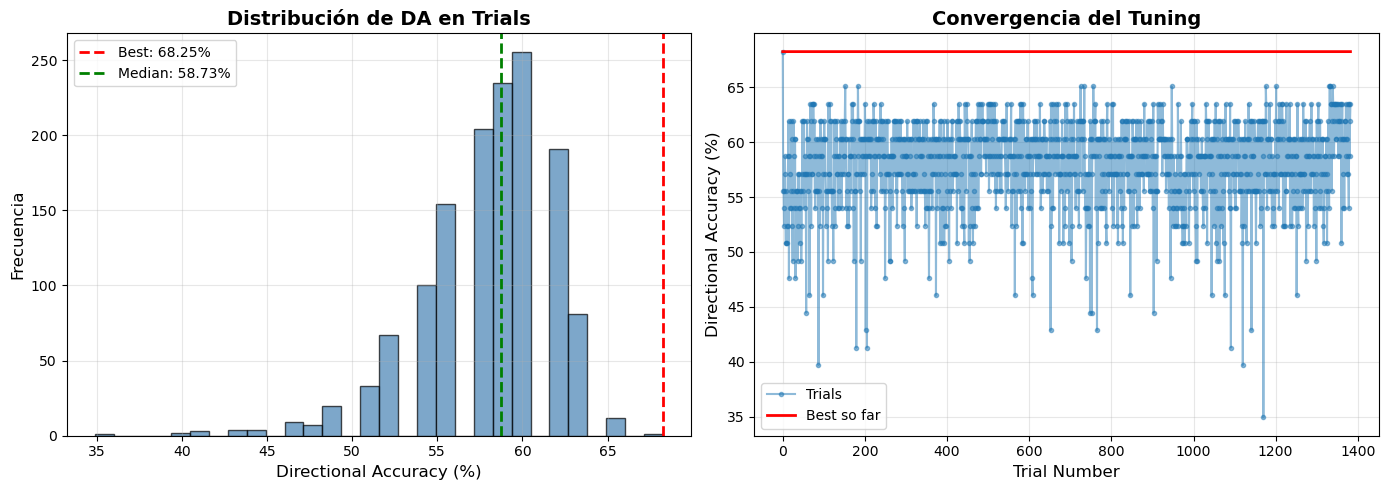


💾 Gráfico guardado en: reports\catboost/tuning_analysis.png
💾 Resumen guardado en: reports\catboost/tuning_summary.json


In [16]:
# ============================================================================
# CELDA 7: ANÁLISIS POST-TUNING
# ============================================================================

print("="*70)
print("📊 ANÁLISIS DE RESULTADOS DEL TUNING")
print("="*70)

# Obtener DataFrame de trials
trials_df = study.trials_dataframe()
trials_df = trials_df[trials_df['value'].notna()].copy()

print(f"\n📈 Estadísticas de Directional Accuracy:")
print(f"   Trials completados: {len(trials_df)}")
print(f"   Media:     {trials_df['value'].mean():.2f}%")
print(f"   Mediana:   {trials_df['value'].median():.2f}%")
print(f"   Desv. Std: {trials_df['value'].std():.2f}%")
print(f"   Mínimo:    {trials_df['value'].min():.2f}%")
print(f"   Máximo:    {trials_df['value'].max():.2f}%")
print(f"   Q1 (25%):  {trials_df['value'].quantile(0.25):.2f}%")
print(f"   Q3 (75%):  {trials_df['value'].quantile(0.75):.2f}%")

# Top 10 trials
print(f"\n🏆 TOP 10 CONFIGURACIONES:")
print("-"*70)
top_10 = trials_df.nlargest(10, 'value')[[
    'number', 'value', 'params_iterations', 'params_depth', 
    'params_learning_rate', 'params_l2_leaf_reg'
]]
print(top_10.to_string(index=False))

# Análisis del mejor trial
best_da = trials_df['value'].max()
second_best = trials_df['value'].nlargest(2).iloc[1] if len(trials_df) > 1 else 0
gap = best_da - second_best

print(f"\n🔍 Análisis del Trial ganador:")
print(f"   Best DA:        {best_da:.2f}%")
print(f"   Second best DA: {second_best:.2f}%")
print(f"   Gap:            {gap:.2f}%")

if gap > 5:
    print(f"   ⚠️  Gap grande (>{gap:.1f}%): Posible overfitting del Trial {study.best_trial.number}")
    print(f"      Considera usar el segundo mejor trial para más robustez")
elif gap > 3:
    print(f"   ⚠️  Gap moderado: Monitorear holdout cuidadosamente")
else:
    print(f"   ✅ Gap razonable: Varios trials tienen performance similar")

# Histograma de distribución
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma de DA
axes[0].hist(trials_df['value'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(best_da, color='red', linestyle='--', linewidth=2, 
                label=f'Best: {best_da:.2f}%')
axes[0].axvline(trials_df['value'].median(), color='green', linestyle='--', 
                linewidth=2, label=f'Median: {trials_df["value"].median():.2f}%')
axes[0].set_xlabel('Directional Accuracy (%)', fontsize=12)
axes[0].set_ylabel('Frecuencia', fontsize=12)
axes[0].set_title('Distribución de DA en Trials', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Convergencia
axes[1].plot(trials_df['number'], trials_df['value'], alpha=0.5, marker='o', 
             markersize=3, label='Trials')
axes[1].plot(trials_df['number'], trials_df['value'].cummax(), 'r-', 
             linewidth=2, label='Best so far')
axes[1].set_xlabel('Trial Number', fontsize=12)
axes[1].set_ylabel('Directional Accuracy (%)', fontsize=12)
axes[1].set_title('Convergencia del Tuning', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(DIRS['reports'] / 'tuning_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n💾 Gráfico guardado en: {DIRS['reports']}/tuning_analysis.png")

# Guardar resumen
tuning_summary = {
    'n_trials': len(trials_df),
    'best_trial_number': int(study.best_trial.number),
    'best_da': float(best_da),
    'best_params': best_params,
    'da_statistics': {
        'mean': float(trials_df['value'].mean()),
        'median': float(trials_df['value'].median()),
        'std': float(trials_df['value'].std()),
        'min': float(trials_df['value'].min()),
        'max': float(trials_df['value'].max()),
        'q25': float(trials_df['value'].quantile(0.25)),
        'q75': float(trials_df['value'].quantile(0.75))
    },
    'gap_to_second_best': float(gap),
    'tuning_time_minutes': elapsed_tune / 60,
    'timestamp': datetime.now().isoformat()
}

with open(DIRS['reports'] / 'tuning_summary.json', 'w') as f:
    json.dump(tuning_summary, f, indent=2)

print(f"💾 Resumen guardado en: {DIRS['reports']}/tuning_summary.json")

In [17]:
# ============================================================================
# CELDA 8: ENTRENAR MODELO FINAL
# ============================================================================

print("="*70)
print("🚀 ENTRENAMIENTO DEL MODELO FINAL")
print("="*70)

start_train = time.time()

# Usar los mejores parámetros
final_params = best_params.copy()
final_params.update({
    'random_seed': EXPERIMENT_CONFIG['random_seed'],
    'verbose': True,
    'task_type': 'GPU',
    'devices': '0'
})

print(f"\n📋 Configuración del modelo final:")
for k, v in final_params.items():
    print(f"   {k:20s}: {v}")

print(f"\n📊 Datos de entrenamiento:")
print(f"   Observaciones: {len(train_full)}")
print(f"   Features: {len(all_features)}")
print(f"   Periodo: {train_full['Fecha'].min()} a {train_full['Fecha'].max()}")

# Entrenar modelo final
final_model = CatBoostWrapper(all_features, final_params)
final_model.fit(train_full[all_features], train_full['PEN_log_ret'])

elapsed_train = time.time() - start_train

print(f"\n✅ Modelo entrenado en {elapsed_train:.2f} segundos")

# Guardar modelo
model_path = DIRS['checkpoints'] / 'catboost_final_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(final_model, f)

print(f"💾 Modelo guardado en: {model_path}")

# Guardar configuración completa
model_config = {
    'model_name': EXPERIMENT_CONFIG['model_name'],
    'model_family': 'tree_based',
    'train_size': len(train_full),
    'n_features': len(all_features),
    'features': all_features,
    'hyperparameters': final_params,
    'train_period': {
        'start': str(train_full['Fecha'].min()),
        'end': str(train_full['Fecha'].max())
    },
    'cv_performance': float(best_da),
    'timestamp': datetime.now().isoformat()
}

with open(DIRS['reports'] / 'model_config.json', 'w') as f:
    json.dump(model_config, f, indent=2)

print(f"💾 Configuración guardada en: {DIRS['reports']}/model_config.json")

🚀 ENTRENAMIENTO DEL MODELO FINAL

📋 Configuración del modelo final:
   iterations          : 106
   depth               : 8
   learning_rate       : 0.1205712628744377
   l2_leaf_reg         : 12
   random_seed         : 42
   verbose             : True
   task_type           : GPU
   devices             : 0

📊 Datos de entrenamiento:
   Observaciones: 8140
   Features: 34
   Periodo: 1994-02-01 00:00:00 a 2025-04-14 00:00:00

✅ Modelo entrenado en 0.74 segundos
💾 Modelo guardado en: checkpoints\catboost\catboost_final_model.pkl
💾 Configuración guardada en: reports\catboost/model_config.json


In [18]:
# %%
# ============================================================================
# CELDA 8.5: GENERAR PREDICCIONES OOF PARA META-LEARNER (WALK-FORWARD)
# ============================================================================

print("="*70)
print("🎯 GENERANDO PREDICCIONES OOF PARA META-LEARNER")
print("="*70)

# Parámetros Walk-Forward
MIN_TRAIN = EXPERIMENT_CONFIG['min_train_size']  # 252
STEP_SIZE = EXPERIMENT_CONFIG['step_size']  # 21

# Calcular número de splits
n_total = len(train_full)
n_splits = (n_total - MIN_TRAIN) // STEP_SIZE

print(f"\n📐 Configuración Walk-Forward:")
print(f"   Min train: {MIN_TRAIN} obs")
print(f"   Step size: {STEP_SIZE} días")
print(f"   Total splits: {n_splits}")
print(f"   Datos train: {n_total} obs")

# Arrays para predicciones OOF
all_predictions = []
all_actuals = []
all_dates = []
fold_metrics = []

# Usar best_params del tuning
oof_params = best_params.copy()
oof_params.update({
    'random_seed': EXPERIMENT_CONFIG['random_seed'],
    'verbose': False,
    'task_type': 'GPU',
    'devices': '0'
})

print(f"   Usando best_params del tuning")

print(f"\n🔄 Iniciando Walk-Forward CV...")
start_oof = time.time()

for i in range(n_splits):
    train_end = MIN_TRAIN + (i * STEP_SIZE)
    test_start = train_end
    test_end = min(train_end + STEP_SIZE, n_total)
    
    if test_start >= n_total:
        break
    
    # Split data
    train_fold = train_full.iloc[:train_end]
    test_fold = train_full.iloc[test_start:test_end]
    
    if len(test_fold) == 0:
        break
    
    # Entrenar modelo en fold
    try:
        fold_model = CatBoostWrapper(all_features, oof_params)
        fold_model.fit(train_fold[all_features], train_fold['PEN_log_ret'])
        
        # Predecir en test fold
        preds = fold_model.predict(test_fold[all_features])
        actuals = test_fold['PEN_log_ret'].values
        dates = test_fold['Fecha'].values
        
        # Guardar predicciones
        all_predictions.extend(preds)
        all_actuals.extend(actuals)
        all_dates.extend(dates)
        
        # Métricas del split
        da = compute_directional_accuracy(actuals, preds)
        mae = np.mean(np.abs(actuals - preds))
        
        fold_metrics.append({
            'split': i + 1,
            'train_size': len(train_fold),
            'val_size': len(test_fold),
            'da': da,
            'mae': mae
        })
        
        # Mostrar progreso cada 50 splits
        if (i + 1) % 50 == 0 or i == 0:
            print(f"   Split {i+1:>3}/{n_splits}: Train={len(train_fold):>5} | Val={len(test_fold):>2} | DA={da:.1f}%")
            
    except Exception as e:
        print(f"   ⚠️ Error en split {i+1}: {str(e)}")
        continue

elapsed_oof = time.time() - start_oof

# Convertir a arrays
oof_predictions = np.array(all_predictions)
oof_actuals = np.array(all_actuals)
oof_dates = np.array(all_dates)

# Verificaciones
n_zeros = (oof_predictions == 0).sum()

# Métricas globales OOF
da_oof = compute_directional_accuracy(oof_actuals, oof_predictions)
mae_oof = np.mean(np.abs(oof_actuals - oof_predictions))

# MASE OOF
naive_mae = np.mean(np.abs(np.diff(train_full['PEN_log_ret'].iloc[:MIN_TRAIN].values)))
mase_oof = mae_oof / naive_mae if naive_mae != 0 else np.inf

print(f"\n{'='*70}")
print(f"📊 MÉTRICAS OOF GLOBALES:")
print(f"{'='*70}")
print(f"   Tiempo: {elapsed_oof/60:.1f} minutos")
print(f"   Observaciones: {len(oof_predictions)}")
print(f"   Predicciones = 0: {n_zeros} {'✅' if n_zeros == 0 else '⚠️'}")
print(f"   DA:   {da_oof:.2f}%")
print(f"   MAE:  {mae_oof:.6f}")
print(f"   MASE: {mase_oof:.4f}")

# Guardar OOF
save_oof_predictions(
    predictions=oof_predictions,
    dates=oof_dates,
    actuals=oof_actuals,
    model_name='CATBOOST',
    prediction_type='log_returns',
    metadata={
        'method': 'walk_forward',
        'min_train': MIN_TRAIN,
        'step_size': STEP_SIZE,
        'n_splits': n_splits,
        'n_observations': len(oof_predictions),
        'n_zeros': int(n_zeros),
        'model': 'CatBoost',
        'hyperparameters': oof_params,
        'da_oof': float(da_oof),
        'mae_oof': float(mae_oof),
        'mase_oof': float(mase_oof),
        'elapsed_minutes': float(elapsed_oof/60),
        'fold_metrics': fold_metrics
    },
    output_dir=str(DIRS['oof'])
)

print(f"\n✅ OOF completado exitosamente")
print(f"   📁 Guardado en: {DIRS['oof']}/train_oof_CATBOOST.csv")

🎯 GENERANDO PREDICCIONES OOF PARA META-LEARNER

📐 Configuración Walk-Forward:
   Min train: 252 obs
   Step size: 21 días
   Total splits: 375
   Datos train: 8140 obs
   Usando best_params del tuning

🔄 Iniciando Walk-Forward CV...
   Split   1/375: Train=  252 | Val=21 | DA=52.4%
   Split  50/375: Train= 1281 | Val=21 | DA=61.9%
   Split 100/375: Train= 2331 | Val=21 | DA=52.4%
   Split 150/375: Train= 3381 | Val=21 | DA=52.4%
   Split 200/375: Train= 4431 | Val=21 | DA=28.6%
   Split 250/375: Train= 5481 | Val=21 | DA=23.8%
   Split 300/375: Train= 6531 | Val=21 | DA=38.1%
   Split 350/375: Train= 7581 | Val=21 | DA=61.9%

📊 MÉTRICAS OOF GLOBALES:
   Tiempo: 35.6 minutos
   Observaciones: 7875
   Predicciones = 0: 0 ✅
   DA:   48.55%
   MAE:  0.001960
   MASE: 0.5333

✅ Guardado OOF: train_oof_CATBOOST.csv
   📊 Observaciones: 7875
   📅 Rango: 1995-01-19T00:00:00.000000000 a 2025-03-26T00:00:00.000000000

✅ OOF completado exitosamente
   📁 Guardado en: oof_predictions/train_oof_CATBO

In [19]:
# ============================================================================
# CELDA 9: PREDICCIONES EN HOLDOUT (ROLLING WINDOW SIN REENTRENAMIENTO)
# ============================================================================

print("="*70)
print("🔮 GENERANDO PREDICCIONES EN HOLDOUT")
print("="*70)

# ⚠️ METODOLOGÍA CRÍTICA: Rolling Forecast h=1 sin reentrenamiento
print(f"\n📐 Metodología:")
print(f"   Horizonte: h=1 (one-step-ahead)")
print(f"   Método: Rolling window SIN reentrenamiento")
print(f"   Step size: {EXPERIMENT_CONFIG['step_size']} días")
print(f"   Total predicciones: {len(holdout)}")

step = EXPERIMENT_CONFIG['step_size']
predictions = []

print(f"\n🔄 Generando predicciones por ventanas...")

for i in range(0, len(holdout), step):
    end_idx = min(i + step, len(holdout))
    window = holdout.iloc[i:end_idx]
    
    # Predecir en esta ventana (sin reentrenar)
    y_pred = final_model.predict(window[all_features])
    
    # Guardar predicciones
    for j, pred in enumerate(y_pred):
        predictions.append({
            'Fecha': window.iloc[j]['Fecha'],
            'y_true': window.iloc[j]['PEN_log_ret'],
            'y_pred': pred,
            'window': i // step
        })
    
    print(f"   Window {i//step + 1}: {len(window)} predicciones")

pred_df = pd.DataFrame(predictions)

print(f"\n✅ {len(pred_df)} predicciones generadas")
print(f"   Periodo: {pred_df['Fecha'].min()} a {pred_df['Fecha'].max()}")

# Verificación crítica
assert len(pred_df) == EXPERIMENT_CONFIG['n_holdout'], \
    f"❌ ERROR: Se esperaban {EXPERIMENT_CONFIG['n_holdout']} predicciones, se obtuvieron {len(pred_df)}"

print(f"✅ Verificación: {len(pred_df)} predicciones = {EXPERIMENT_CONFIG['n_holdout']} (correcto)")

🔮 GENERANDO PREDICCIONES EN HOLDOUT

📐 Metodología:
   Horizonte: h=1 (one-step-ahead)
   Método: Rolling window SIN reentrenamiento
   Step size: 21 días
   Total predicciones: 60

🔄 Generando predicciones por ventanas...
   Window 1: 21 predicciones
   Window 2: 21 predicciones
   Window 3: 18 predicciones

✅ 60 predicciones generadas
   Periodo: 2025-04-15 00:00:00 a 2025-07-07 00:00:00
✅ Verificación: 60 predicciones = 60 (correcto)


In [20]:
# ============================================================================
# CELDA 10: CÁLCULO DE MÉTRICAS EN HOLDOUT
# ============================================================================

print("="*70)
print("📊 EVALUACIÓN DE MÉTRICAS EN HOLDOUT")
print("="*70)

# Directional Accuracy
da_holdout = compute_directional_accuracy(
    pred_df['y_true'].values, 
    pred_df['y_pred'].values
)

# MAE
mae_holdout = np.mean(np.abs(pred_df['y_true'] - pred_df['y_pred']))

# RMSE
rmse_holdout = np.sqrt(np.mean((pred_df['y_true'] - pred_df['y_pred'])**2))

# MASE (Mean Absolute Scaled Error)
# Escalar por el MAE de naive forecast (random walk)
naive_forecast = train_full['PEN_log_ret'].iloc[:-1].values  # t-1 predice t
naive_actual = train_full['PEN_log_ret'].iloc[1:].values
mae_naive = np.mean(np.abs(naive_actual - naive_forecast))
mase_holdout = mae_holdout / mae_naive if mae_naive != 0 else np.inf

# Imprimir resultados
print(f"\n{'='*70}")
print(f"MÉTRICAS EN HOLDOUT ({len(pred_df)} observaciones)")
print(f"{'='*70}")
print(f"Directional Accuracy (DA): {da_holdout:.2f}%")
print(f"Mean Absolute Scaled Error (MASE): {mase_holdout:.4f}")
print(f"Mean Absolute Error (MAE): {mae_holdout:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse_holdout:.6f}")
print(f"{'='*70}")

# Comparar con CV
print(f"\n🔍 Comparación CV vs Holdout:")
print(f"   DA en CV:      {best_da:.2f}%")
print(f"   DA en Holdout: {da_holdout:.2f}%")
print(f"   Diferencia:    {best_da - da_holdout:.2f}%")

if abs(best_da - da_holdout) < 3:
    print(f"   ✅ Diferencia pequeña (<3%): Buena generalización")
elif abs(best_da - da_holdout) < 6:
    print(f"   ⚠️  Diferencia moderada (3-6%): Ligero overfitting en CV")
else:
    print(f"   🚨 Diferencia grande (>6%): Overfitting severo en CV")

# Análisis de direccionalidad
correct_signs = np.sign(pred_df['y_true']) == np.sign(pred_df['y_pred'])
print(f"\n📈 Análisis de predicciones:")
print(f"   Predicciones correctas: {correct_signs.sum()} / {len(pred_df)}")
print(f"   Predicciones incorrectas: {(~correct_signs).sum()} / {len(pred_df)}")
print(f"   % Subidas predichas correctamente: {(np.sign(pred_df[pred_df['y_true'] > 0]['y_pred']) == 1).mean()*100:.1f}%")
print(f"   % Bajadas predichas correctamente: {(np.sign(pred_df[pred_df['y_true'] < 0]['y_pred']) == -1).mean()*100:.1f}%")

# Guardar métricas
metrics = {
    'model_name': EXPERIMENT_CONFIG['model_name'],
    'n_holdout': len(pred_df),
    'holdout_period': {
        'start': str(pred_df['Fecha'].min()),
        'end': str(pred_df['Fecha'].max())
    },
    'cv_performance': {
        'da_pct': float(best_da)
    },
    'holdout_metrics': {
        'da_pct': float(da_holdout),
        'mase': float(mase_holdout),
        'mae': float(mae_holdout),
        'rmse': float(rmse_holdout)
    },
    'generalization': {
        'cv_holdout_gap': float(best_da - da_holdout)
    },
    'timestamp': datetime.now().isoformat()
}

with open(DIRS['reports'] / 'holdout_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)

print(f"\n💾 Métricas guardadas en: {DIRS['reports']}/holdout_metrics.json")

📊 EVALUACIÓN DE MÉTRICAS EN HOLDOUT

MÉTRICAS EN HOLDOUT (60 observaciones)
Directional Accuracy (DA): 60.00%
Mean Absolute Scaled Error (MASE): 0.9116
Mean Absolute Error (MAE): 0.002539
Root Mean Squared Error (RMSE): 0.003214

🔍 Comparación CV vs Holdout:
   DA en CV:      68.25%
   DA en Holdout: 60.00%
   Diferencia:    8.25%
   🚨 Diferencia grande (>6%): Overfitting severo en CV

📈 Análisis de predicciones:
   Predicciones correctas: 36 / 60
   Predicciones incorrectas: 24 / 60
   % Subidas predichas correctamente: 63.6%
   % Bajadas predichas correctamente: 64.7%

💾 Métricas guardadas en: reports\catboost/holdout_metrics.json


📊 Generando visualizaciones...


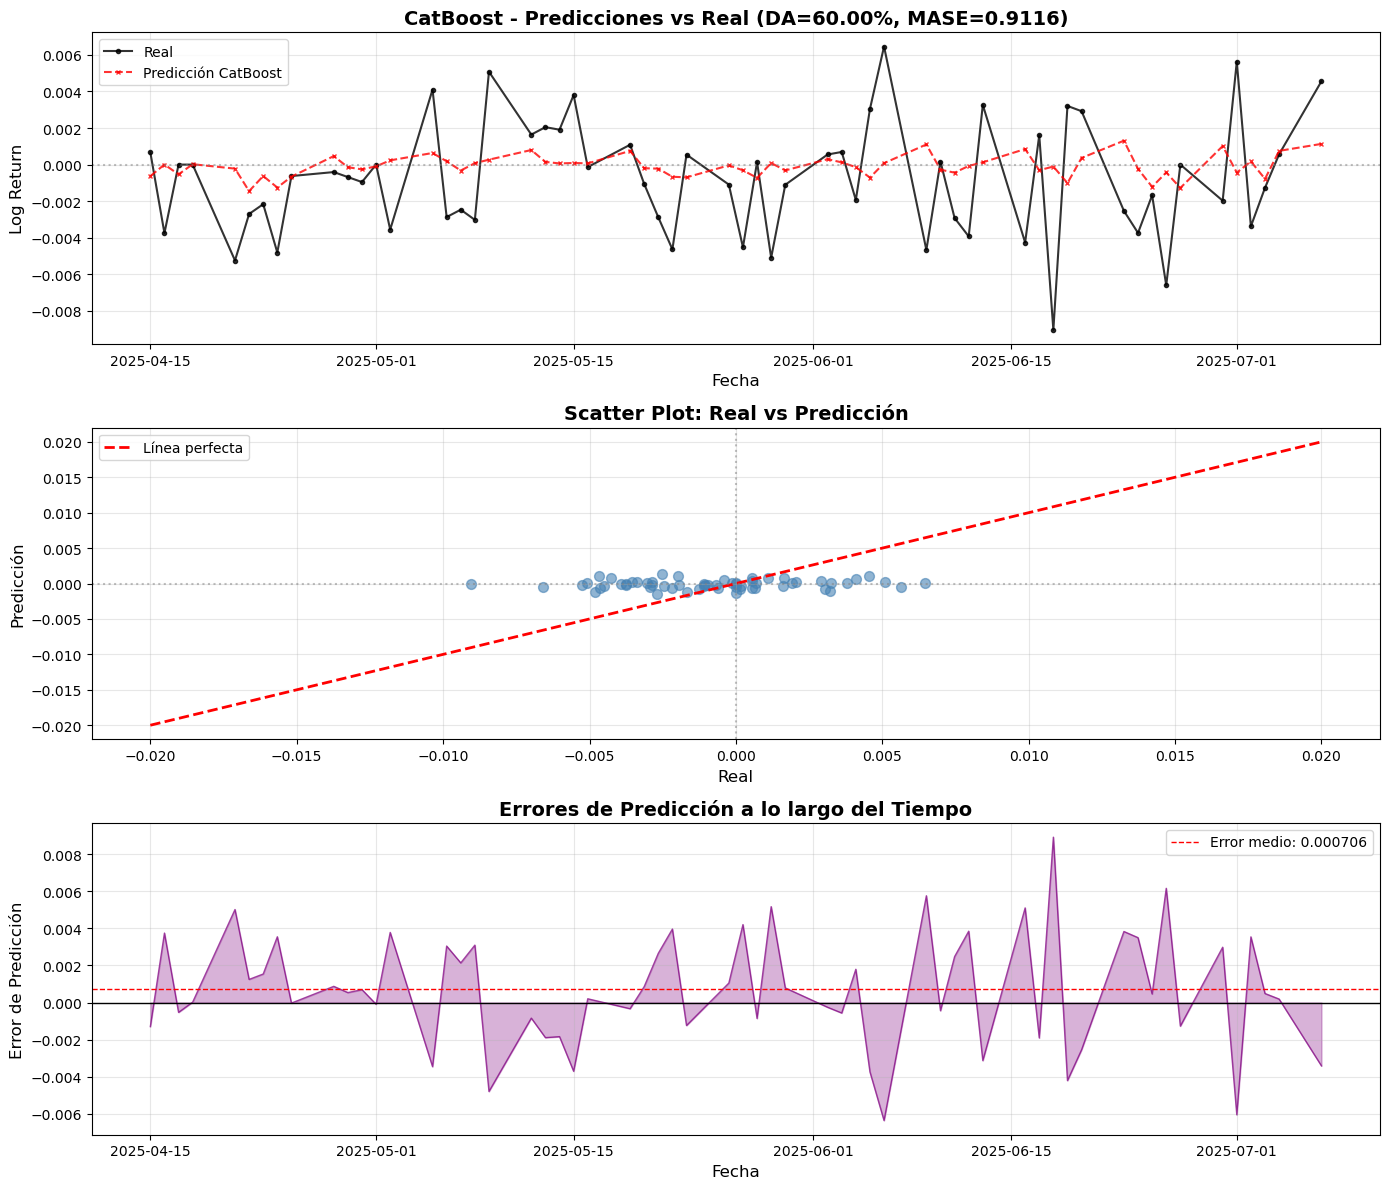

✅ Visualización guardada en: reports\catboost/predictions_visualization.png


In [21]:
# ============================================================================
# CELDA 11: VISUALIZACIÓN DE PREDICCIONES
# ============================================================================

print("📊 Generando visualizaciones...")

fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# ============================================================================
# PLOT 1: Series temporales
# ============================================================================
axes[0].plot(pred_df['Fecha'], pred_df['y_true'], 
             label='Real', color='black', linewidth=1.5, alpha=0.8, marker='o', markersize=3)
axes[0].plot(pred_df['Fecha'], pred_df['y_pred'], 
             label='Predicción CatBoost', color='red', linewidth=1.5, alpha=0.8, 
             linestyle='--', marker='x', markersize=3)
axes[0].axhline(0, color='gray', linestyle=':', alpha=0.5)
axes[0].set_title(f'CatBoost - Predicciones vs Real (DA={da_holdout:.2f}%, MASE={mase_holdout:.4f})', 
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Fecha', fontsize=12)
axes[0].set_ylabel('Log Return', fontsize=12)
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(alpha=0.3)

# ============================================================================
# PLOT 2: Scatter plot
# ============================================================================
axes[1].scatter(pred_df['y_true'], pred_df['y_pred'], alpha=0.6, s=50, color='steelblue')
axes[1].plot([-0.02, 0.02], [-0.02, 0.02], 'r--', linewidth=2, label='Línea perfecta')

# Añadir cuadrantes
axes[1].axhline(0, color='gray', linestyle=':', alpha=0.5)
axes[1].axvline(0, color='gray', linestyle=':', alpha=0.5)

axes[1].set_xlabel('Real', fontsize=12)
axes[1].set_ylabel('Predicción', fontsize=12)
axes[1].set_title('Scatter Plot: Real vs Predicción', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

# ============================================================================
# PLOT 3: Errores a lo largo del tiempo
# ============================================================================
errors = pred_df['y_pred'] - pred_df['y_true']
axes[2].plot(pred_df['Fecha'], errors, color='purple', linewidth=1, alpha=0.7)
axes[2].axhline(0, color='black', linestyle='-', linewidth=1)
axes[2].axhline(errors.mean(), color='red', linestyle='--', linewidth=1, 
                label=f'Error medio: {errors.mean():.6f}')
axes[2].fill_between(pred_df['Fecha'], 0, errors, alpha=0.3, color='purple')
axes[2].set_xlabel('Fecha', fontsize=12)
axes[2].set_ylabel('Error de Predicción', fontsize=12)
axes[2].set_title('Errores de Predicción a lo largo del Tiempo', fontsize=14, fontweight='bold')
axes[2].legend(fontsize=10)
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(DIRS['reports'] / 'predictions_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Visualización guardada en: {DIRS['reports']}/predictions_visualization.png")

In [22]:
# ============================================================================
# CELDA 12: EXPORT HOMOGENEIZADO PARA META-LEARNER
# ============================================================================

print("="*70)
print("📦 EXPORTANDO PREDICCIONES PARA META-LEARNER")
print("="*70)

# ⚠️ FORMATO ESTÁNDAR: ['ds', 'y_pred', 'model', 'type']
# Compatible con pred_ARX.csv, pred_ChronosX.csv, etc.

export_df = pd.DataFrame({
    'ds': pred_df['Fecha'],
    'y_pred': pred_df['y_pred'],
    'model': 'CATBOOST',
    'type': 'log_returns'
})

# Verificaciones finales
print(f"\n🔍 Verificaciones pre-export:")
print(f"   ✅ Shape: {export_df.shape}")
print(f"   ✅ Columnas: {list(export_df.columns)}")
print(f"   ✅ N_HOLDOUT: {len(export_df)} == {EXPERIMENT_CONFIG['n_holdout']}")
print(f"   ✅ NaNs: {export_df.isna().sum().sum()}")

assert len(export_df) == EXPERIMENT_CONFIG['n_holdout'], "Error en número de predicciones"
assert export_df.isna().sum().sum() == 0, "Hay NaNs en las predicciones"
assert list(export_df.columns) == ['ds', 'y_pred', 'model', 'type'], "Formato de columnas incorrecto"

# Guardar en predictions_dump
export_path = DIRS['predictions'] / 'pred_CATBOOST.csv'
export_df.to_csv(export_path, index=False)

print(f"\n✅ Predicciones exportadas:")
print(f"   Path: {export_path}")
print(f"   Formato: Compatible con otros 7 modelos")

# Mostrar muestra
print(f"\n📋 Muestra del export:")
print(export_df.head(10).to_string(index=False))

# Metadata adicional (JSON para meta-learner)
export_metadata = {
    'metadata': {
        'model_name': 'CATBOOST',
        'model_family': 'tree_based',
        'version': '1.0',
        'exported_at': datetime.now().isoformat(),
        'n_predictions': len(export_df),
        'step_size': EXPERIMENT_CONFIG['step_size'],
        'n_holdout': EXPERIMENT_CONFIG['n_holdout'],
        'n_features': len(all_features),
        'best_hyperparameters': best_params,
        'cv_performance': {'da_pct': float(best_da)},
        'holdout_metrics': {
            'da_pct': float(da_holdout),
            'mase': float(mase_holdout),
            'mae': float(mae_holdout),
            'rmse': float(rmse_holdout)
        }
    },
    'predictions': export_df.to_dict(orient='records')
}

export_json_path = DIRS['reports'] / 'catboost_predictions_full.json'
with open(export_json_path, 'w') as f:
    json.dump(export_metadata, f, indent=2, default=str)

print(f"\n💾 Metadata completa guardada en: {export_json_path}")

print(f"\n{'='*70}")
print(f"🎉 CATBOOST COMPLETADO Y LISTO PARA ENSEMBLE")
print(f"{'='*70}")
print(f"\n📊 Resumen Final:")
print(f"   Modelo: CatBoost (Tree-based)")
print(f"   Features: {len(all_features)}")
print(f"   CV DA: {best_da:.2f}%")
print(f"   Holdout DA: {da_holdout:.2f}%")
print(f"   Holdout MASE: {mase_holdout:.4f}")
print(f"   Predicciones: {len(export_df)}")
print(f"   Export: {export_path}")
print(f"\n✅ Modelo #8 del ensemble completado")

📦 EXPORTANDO PREDICCIONES PARA META-LEARNER

🔍 Verificaciones pre-export:
   ✅ Shape: (60, 4)
   ✅ Columnas: ['ds', 'y_pred', 'model', 'type']
   ✅ N_HOLDOUT: 60 == 60
   ✅ NaNs: 0

✅ Predicciones exportadas:
   Path: predictions_dump\pred_CATBOOST.csv
   Formato: Compatible con otros 7 modelos

📋 Muestra del export:
        ds    y_pred    model        type
2025-04-15 -0.000633 CATBOOST log_returns
2025-04-16  0.000003 CATBOOST log_returns
2025-04-17 -0.000535 CATBOOST log_returns
2025-04-18  0.000021 CATBOOST log_returns
2025-04-21 -0.000221 CATBOOST log_returns
2025-04-22 -0.001452 CATBOOST log_returns
2025-04-23 -0.000625 CATBOOST log_returns
2025-04-24 -0.001256 CATBOOST log_returns
2025-04-25 -0.000658 CATBOOST log_returns
2025-04-28  0.000464 CATBOOST log_returns

💾 Metadata completa guardada en: reports\catboost\catboost_predictions_full.json

🎉 CATBOOST COMPLETADO Y LISTO PARA ENSEMBLE

📊 Resumen Final:
   Modelo: CatBoost (Tree-based)
   Features: 34
   CV DA: 68.25%
   Holdo